In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

import sys, os, importlib, seaborn as sns

outputDirectory = 'raw/'
parentDirectory = 'data/'
sys.path.append('../../')
sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation/')
from scipy.interpolate import interp1d
import os, sys, pandas as pd, seaborn as sns, scipy.optimize as opt, scipy.constants as cst

import default_style as dfs

palette = sns.color_palette("bwr", as_cmap=True)

def get_fluence_steps(fpath):
    return pd.read_excel(fpath, sheet_name='fluence_steps', usecols=[0, 1, 2], names=['step', 'step_fluence', 'cumulated_fluence'])

def get_metadata(tape):
    tirr, tapeid = int(tape.split('k_')[0]), tape.split('k_')[1]
    label = '$\mathrm{T^{irr}}$ '+'= {:>3} K | {:<5}'.format(tirr, tapeid)#+'\t\t$\mathrm{T^{irr}}$ = '+'{:>3} K'.format(tirr)
    return tirr, label, palette(tirr/300)
        
import hts_fitting as hts, hts_fitfunctions as ff

def linear_norm(x, a):
    return a*x+1

savedir = '../figures/raw/'

metadata = pd.DataFrame(
    {
        'tapes': [
            '020k_ffj23',
            '020k_ffj28',
            '020k_ffj29',
            '025k_amsc1',
            '077k_ffj6',
            '200k_ffj24',
            '200k_ffj34',
            '300k_ffj33',
            '300k_ffj26',
            '300k_amsc2'
        ],

        'markers': ['o', 'd', '^', 'v', '<', '>', 's', '*', 'P', 'X']
    }
)

metadata

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_24492/3396719942.py:23: SyntaxWarning: invalid escape sequence '\m'
  label = '$\mathrm{T^{irr}}$ '+'= {:>3} K | {:<5}'.format(tirr, tapeid)#+'\t\t$\mathrm{T^{irr}}$ = '+'{:>3} K'.format(tirr)


,tapes,markers
0,020k_ffj23,o
1,020k_ffj28,d
2,020k_ffj29,^
3,025k_amsc1,v
4,077k_ffj6,<
5,200k_ffj24,>
6,200k_ffj34,s
7,300k_ffj33,*
8,300k_ffj26,P
9,300k_amsc2,X


<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_24492/2029546085.py:2: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$t_c\mathrm{ = T_c\; /\; T_c^{unirradiated}}$')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_24492/2029546085.py:3: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('1200 keV proton fluence [$\mathrm{10^{20}\; p/m^2}$]')


The degradation rates for critical temperature are: rhot = -1.69 +/- 0.07 and rcold = -2.76 +/- 0.26


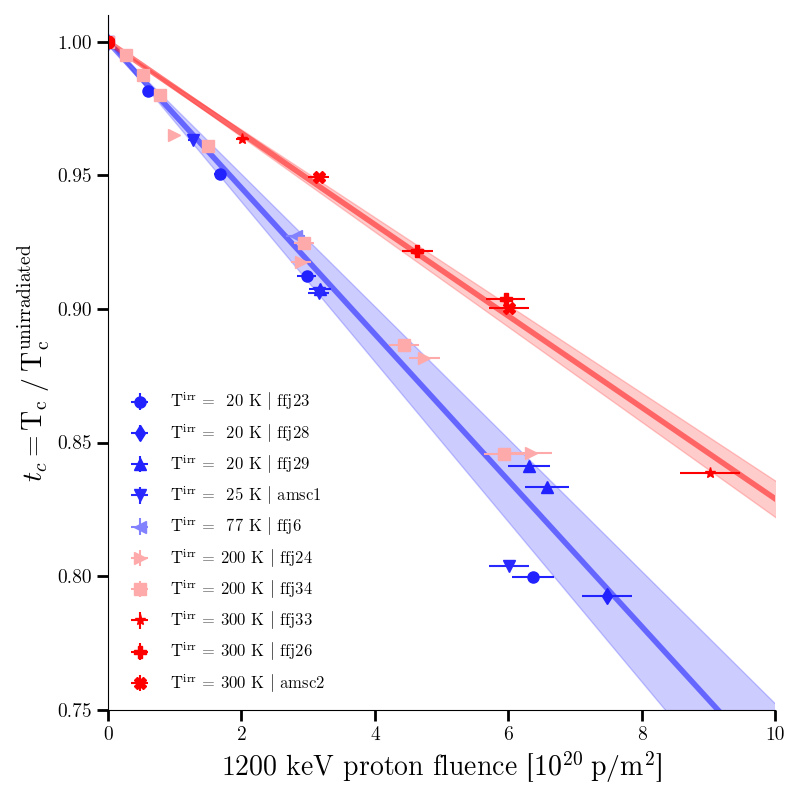

In [2]:
fig, ax = plt.subplots()
ax.set_ylabel('$t_c\mathrm{ = T_c\; /\; T_c^{unirradiated}}$')
ax.set_xlabel('1200 keV proton fluence [$\mathrm{10^{20}\; p/m^2}$]')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0.75, 1.01)
ax.set_xlim(0, 10)

rcold, rhot = [], []
tclo, tchi = [], []
flo, fhi = [], []

for tape, m in zip(metadata.tapes, metadata.markers):
    
    tirr, l, c = get_metadata(tape)
    fpath = 'output/{}-tc_degradation.xlsx'.format(tape)
    data = pd.read_excel(fpath, sheet_name='aggregates')
    
    try:
        y0 = data.tc_mean[data.cumulated_fluence == 0].values[0]
        x = data.cumulated_fluence/1e20
        y = data.tc_mean/y0
        yerr = data.tc_std/y0
        xerr = 0.05*x
        
        popt, pcov = opt.curve_fit(linear_norm, x, y)
        ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, marker=m, linestyle='None', markersize=8, color=c, label=l)

        if tirr == 300:
            rhot.append(popt[0])
            tchi.extend(y)
            fhi.extend(data.cumulated_fluence.values)
        else:
            rcold.append(popt[0])
            tclo.extend(y)
            flo.extend(data.cumulated_fluence.values)
            
    except IndexError as e:
        print(tape, 'has no data for the temperature range ({}, {})'.format(tmin, tmax))

for f, tc, c, rerr in zip([flo, fhi], [tclo, tchi], [palette(0), palette(1.)], [np.std(rcold), np.std(rhot)]):
    xsmooth = np.arange(0, 11, .1)
        
    tcpopt, _ = opt.curve_fit(linear_norm, np.array(f)/1e20, tc)
    ysmooth = linear_norm(xsmooth, *tcpopt)
    ysmooth_hi = linear_norm(xsmooth, tcpopt[0]+rerr)
    ysmooth_lo = linear_norm(xsmooth, tcpopt[0]-rerr)
    
    ax.plot(xsmooth, ysmooth, color=c, zorder=0, linewidth=4, alpha=.5, solid_capstyle='round')
    ax.fill_between(xsmooth, ysmooth_lo, ysmooth_hi, color=c, zorder=0, alpha=.2)

ax.legend(frameon=False)
fig.tight_layout()
plt.savefig(savedir+'tc_degradation.svg', format='svg', transparent=True, dpi=300)

print('The degradation rates for critical temperature are: rhot = {:4.2f} +/- {:4.2f} and rcold = {:4.2f} +/- {:4.2f}'.format(100*np.mean(rhot), 100*np.std(rhot), 100*np.mean(rcold), 100*np.std(rcold)))

attempt to get argmax of an empty sequence
020k_ffj28 has no data for the temperature range (75, 85)
attempt to get argmax of an empty sequence
020k_ffj29 has no data for the temperature range (75, 85)
  temperature_group  cumulated_fluence  temperature_mean  temperature_std  \
4      [77.2, 81.3)       0.000000e+00         77.940002         1.431088   
5      [77.2, 81.3)       1.273918e+20         81.108037         0.096985   
6      [77.2, 81.3)       3.159832e+20         81.015973         0.023930   

    ic_mean    ic_std     n_mean     n_std  file_count  
4  9.318680  0.016844  21.720415  1.627041           5  
5  6.493486  0.020256  18.763451  0.210470           3  
6  2.750286  0.018069  15.202814  0.442300           6  
Cold: -33.0 (Ic), 377.3 (n-value)
Hot: -21.2 (Ic), 377.3 (n-value)
The degradation rates for critical current are: rhot = -22.50 +/- 2.27 and rcold = -33.44 +/- 1.88
The degradation rates for the n-value are: rhot = 553.50 +/- 305.52 and rcold = 808.04 +/- 486.

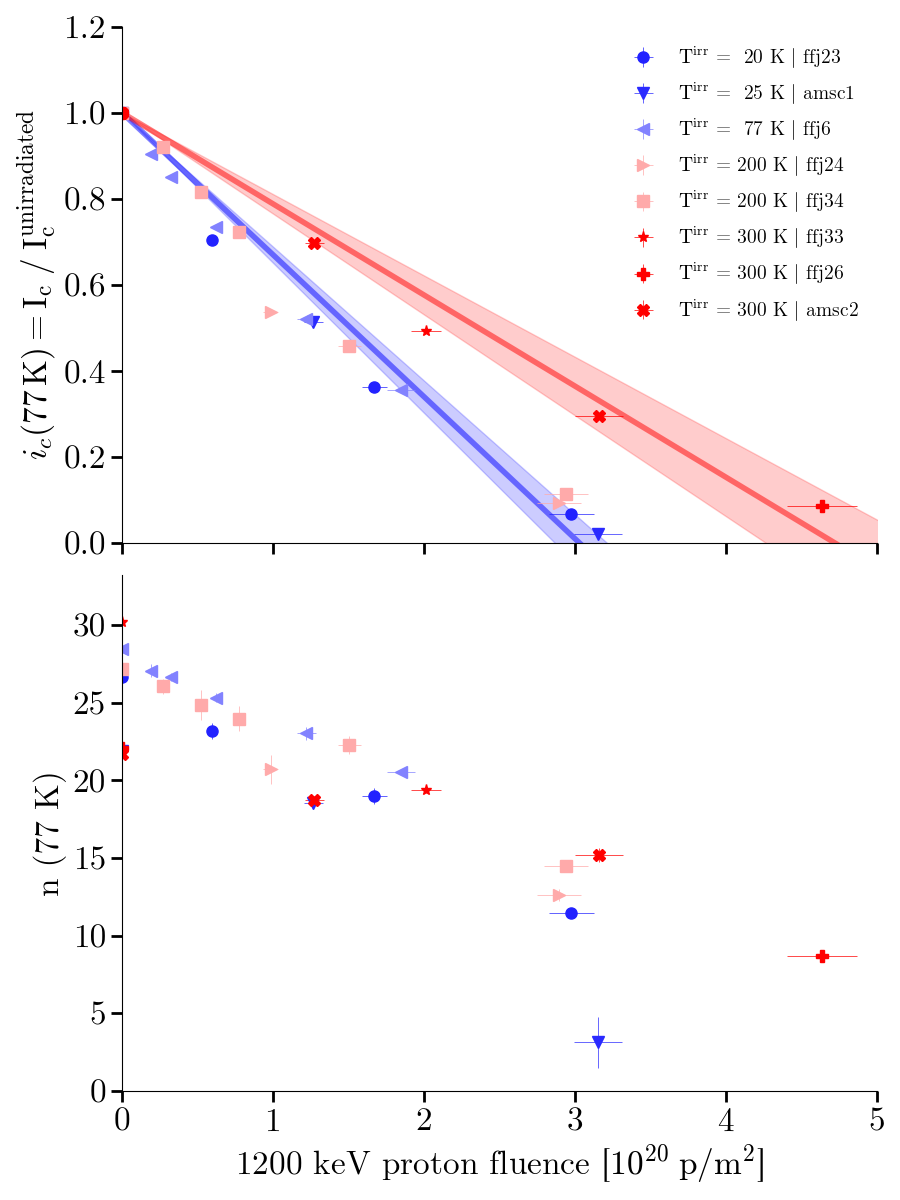

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(9, 12), sharex=True)
ax[0].set_ylabel('$i_c\mathrm{(77\, K) = I_c\; /\; I_c^{unirradiated}}$')
ax[1].set_ylabel('n (77 K)')
#ax[1].set_ylabel('$\hat{n}\mathrm{(77\, K) = n\; /\; n^{unirradiated}}$')
ax[1].set_xlabel('1200 keV proton fluence [$\mathrm{10^{20}\; p/m^2}$]')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].set_ylim(0, 1.2)
#ax[1].set_ylim(0, 1.2)
ax[0].set_xlim(0, 5)

tmin, tmax = 75, 85
iclo, ichi, nlo, nhi, flo, fhi = [], [], [], [], [], []
rcold_n, rhot_n, rcold_ic, rhot_ic = [], [], [], [] # collect the degradation rates

for tape, m in zip(metadata.tapes, metadata.markers):
    
    tirr, l, c = get_metadata(tape)
    fpath = 'output/{}-ic_degradation.xlsx'.format(tape)
    data = pd.read_excel(fpath, sheet_name='aggregates')
    
    try:
        largest_number_fluence_steps = data[(tmin <= data.temperature_mean) & (data.temperature_mean <= tmax)].groupby('temperature_group').count().idxmax()[0]
        data = data[data['temperature_group']==largest_number_fluence_steps]
        if tape == '300k_amsc2':
            print(data)
        # plot Ic in the top subfigure
        ic0 = data.ic_mean[data.cumulated_fluence == 0].values[0]
        x = data.cumulated_fluence/1e20
        y = data.ic_mean/ic0
        yerr = data.ic_std/ic0
        xerr = 0.05*x
        ax[0].errorbar(x=x, y=y, xerr=xerr, yerr=yerr, marker=m, linestyle='None', linewidth=0.5, markersize=8, color=c, label=l)
        
        popt, pcov = opt.curve_fit(linear_norm, x, data.ic_mean/ic0)
        rate_ic = popt[0]
        
        # plot n in the bottom subfigure
        n0 = 1 #data.n_mean[data.cumulated_fluence == 0].values[0]
        x = data.cumulated_fluence/1e20
        y = data.n_mean/n0
        yerr = data.n_std/n0
        xerr = 0.05*x
        ax[1].errorbar(x=x, y=y, xerr=xerr, yerr=yerr, marker=m, linestyle='None', linewidth=0.5, markersize=8, color=c, label=l)
        
        popt, pcov = opt.curve_fit(linear_norm, x, data.n_mean/n0)
        rate_n = popt[0]
        
        if tirr == 300:
            ichi.extend(data.ic_mean.values/ic0)
            nhi.extend(data.n_mean.values/n0)
            fhi.extend(data.cumulated_fluence.values)
            rhot_n.append(rate_n)
            rhot_ic.append(rate_ic)
        else:
            iclo.extend(data.ic_mean.values/ic0)
            nlo.extend(data.n_mean.values/n0)
            flo.extend(data.cumulated_fluence.values)
            rcold_n.append(rate_n)
            rcold_ic.append(rate_ic)
            
    except IndexError as e:
        print(e)
        print(tape, 'has no data for the temperature range ({}, {})'.format(tmin, tmax))
    except ValueError as e:
        print(e)
        print(tape, 'has no data for the temperature range ({}, {})'.format(tmin, tmax))
        

for i, (f, ic, n, c, rerr) in enumerate(zip([flo, fhi], [iclo, ichi], [nlo, nhi], [palette(0), palette(1.)], [np.std(rcold_ic), np.std(rhot_ic)])):
    if i == 0:
        xsmooth = np.arange(0, 4, .1)
    else:
        xsmooth = np.arange(0, 6, .1)
        
    # Fit the critical current data
    icpopt, _ = opt.curve_fit(linear_norm, np.array(f)/1e20, ic)
    ysmooth = linear_norm(xsmooth, *icpopt)
    ysmooth_hi = linear_norm(xsmooth, icpopt[0]+rerr)
    ysmooth_lo = linear_norm(xsmooth, icpopt[0]-rerr)
    ax[0].plot(xsmooth, ysmooth, color=c, zorder=0, linewidth=4, alpha=.5, solid_capstyle='round')
    ax[0].fill_between(xsmooth, ysmooth_lo, ysmooth_hi, color=c, zorder=0, alpha=.2)
    # Fit the n-value data
    #npopt, _ = opt.curve_fit(linear_norm, np.array(f)/1e20, n)
    #ysmooth = linear_norm(xsmooth, *npopt)
    #ax[1].plot(xsmooth, ysmooth, color=c, zorder=0, linewidth=4, alpha=.3, solid_capstyle='round')
    
    if i == 0:
        print('Cold: {:4.1f} (Ic), {:4.1f} (n-value)'.format(100*icpopt[0], 100*npopt[0]))
    else:
        print('Hot: {:4.1f} (Ic), {:4.1f} (n-value)'.format(100*icpopt[0], 100*npopt[0]))


ax[0].legend(frameon=False, fontsize=14)
fig.tight_layout()

plt.savefig(savedir+'ic_degradation_77K.svg', format='svg', transparent=True, dpi=300)

print('The degradation rates for critical current are: rhot = {:4.2f} +/- {:4.2f} and rcold = {:4.2f} +/- {:4.2f}'.format(100*np.mean(rhot_ic), 100*np.std(rhot_ic), 100*np.mean(rcold_ic), 100*np.std(rcold_ic)))
print('The degradation rates for the n-value are: rhot = {:4.2f} +/- {:4.2f} and rcold = {:4.2f} +/- {:4.2f}'.format(100*np.mean(rhot_n), 100*np.std(rhot_n), 100*np.mean(rcold_n), 100*np.std(rcold_n)))

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/3029473926.py:2: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_ylabel('$i_c\mathrm{(20\, K) = I_c\; /\; I_c^{unirradiated}}$')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/3029473926.py:5: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel('1200 keV proton fluence [$\mathrm{10^{20}\; p/m^2}$]')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/3029473926.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  largest_number_fluence_steps = data[(tmin <= data.temperature_mean) & (data.temp

The degradation rates for critical current are: rhot = -9.12 +/- 0.27 and rcold = -14.15 +/- 0.96
The degradation rates for the n-value are: rhot = 481.49 +/- 85.99 and rcold = 663.29 +/- 212.36


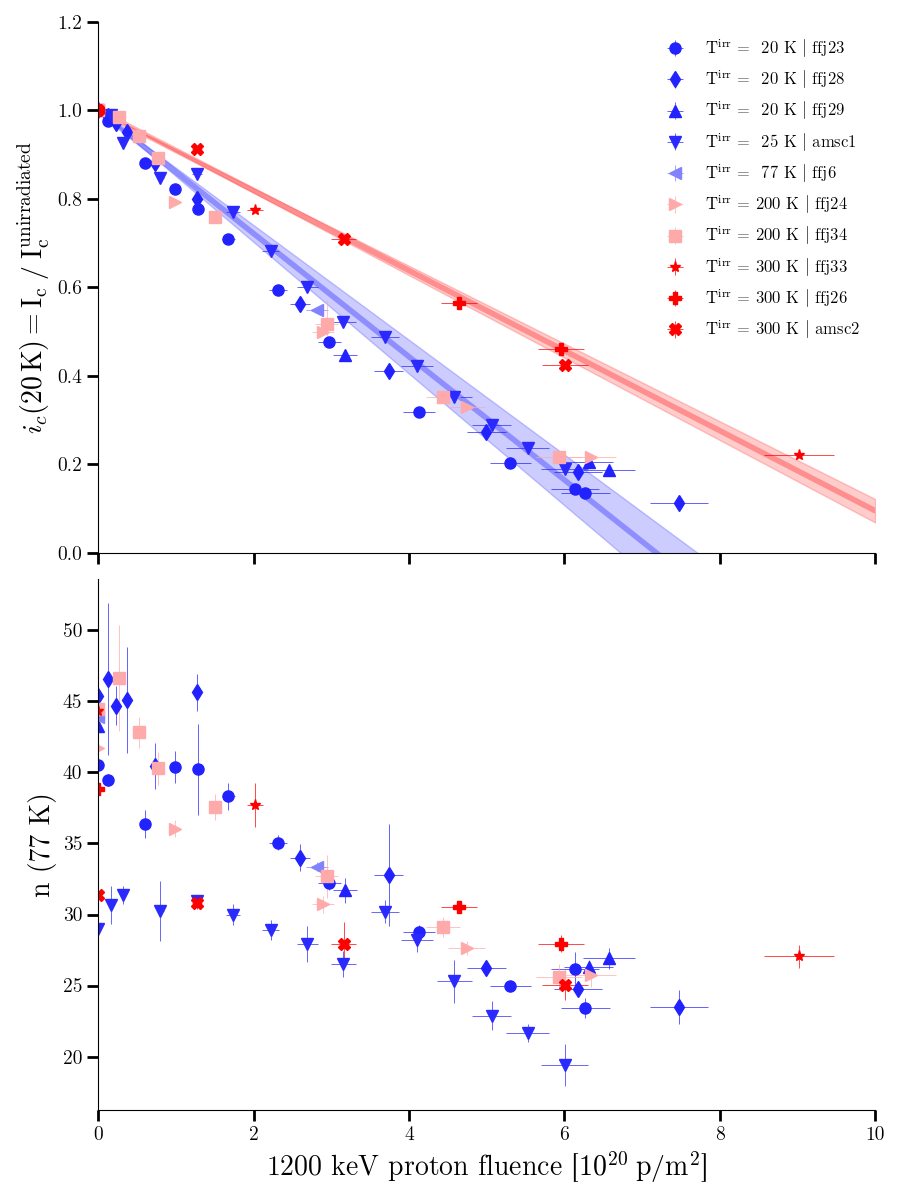

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(9, 12), sharex=True)
ax[0].set_ylabel('$i_c\mathrm{(20\, K) = I_c\; /\; I_c^{unirradiated}}$')
ax[1].set_ylabel('n (77 K)')
#ax[1].set_ylabel('$\hat{n}\mathrm{(20\, K) = n\; /\; n^{unirradiated}}$')
ax[1].set_xlabel('1200 keV proton fluence [$\mathrm{10^{20}\; p/m^2}$]')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].set_ylim(0, 1.2)
#ax[1].set_ylim(0, 1.2)
ax[0].set_xlim(0, 10)

tmin, tmax = 15, 30
iclo, ichi, nlo, nhi, flo, fhi = [], [], [], [], [], []
rcold_n, rhot_n, rcold_ic, rhot_ic = [], [], [], [] # collect the degradation rates

for tape, m in zip(metadata.tapes, metadata.markers):
    
    tirr, l, c = get_metadata(tape)
    fpath = 'output/{}-ic_degradation.xlsx'.format(tape)
    data = pd.read_excel(fpath, sheet_name='aggregates')
    
    try:
        largest_number_fluence_steps = data[(tmin <= data.temperature_mean) & (data.temperature_mean<= tmax)].groupby('temperature_group').count().idxmax()[0]
        data = data[data['temperature_group']==largest_number_fluence_steps]
        
        # plot Ic in the top subfigure
        ic0 = data.ic_mean[data.cumulated_fluence == 0].values[0]
        x = data.cumulated_fluence/1e20
        y = data.ic_mean/ic0
        yerr = data.ic_std/ic0
        xerr = 0.05*x
        ax[0].errorbar(x=x, y=y, xerr=xerr, yerr=yerr, marker=m, linestyle='None', linewidth=0.5, markersize=8, color=c, label=l)
        
        popt, pcov = opt.curve_fit(linear_norm, x, data.ic_mean/ic0)
        rate_ic = popt[0]
        
        # plot n in the bottom subfigure
        n0 = 1 #data.n_mean[data.cumulated_fluence == 0].values[0]
        x = data.cumulated_fluence/1e20
        y = data.n_mean/n0
        yerr = data.n_std/n0
        xerr = 0.05*x
        ax[1].errorbar(x=x, y=y, xerr=xerr, yerr=yerr, marker=m, linestyle='None', linewidth=0.5, markersize=8, color=c, label=l)
        
        popt, pcov = opt.curve_fit(linear_norm, x, data.n_mean/n0)
        rate_n = popt[0]
        
        if tirr == 300:
            ichi.extend(data.ic_mean.values/ic0)
            nhi.extend(data.n_mean.values/n0)
            fhi.extend(data.cumulated_fluence.values)
            rhot_n.append(rate_n)
            rhot_ic.append(rate_ic)
        else:
            iclo.extend(data.ic_mean.values/ic0)
            nlo.extend(data.n_mean.values/n0)
            flo.extend(data.cumulated_fluence.values)
            rcold_n.append(rate_n)
            rcold_ic.append(rate_ic)
            
    except IndexError as e:
        print(tape, 'has no data for the temperature range ({}, {})'.format(tmin, tmax))


for i, (f, ic, n, c, rerr) in enumerate(zip([flo, fhi], [iclo, ichi], [nlo, nhi], [palette(0), palette(1.)], [np.std(rcold_ic), np.std(rhot_ic)])):
    xsmooth = np.arange(0, 11, 1)
    
    icpopt, _ = opt.curve_fit(linear_norm, np.array(f)/1e20, ic)
    ysmooth = linear_norm(xsmooth, *icpopt)
    ysmooth_hi = linear_norm(xsmooth, icpopt[0]+rerr)
    ysmooth_lo = linear_norm(xsmooth, icpopt[0]-rerr)
    ax[0].plot(xsmooth, ysmooth, color=c, zorder=0, linewidth=4, alpha=.3, solid_capstyle='round')
    ax[0].fill_between(xsmooth, ysmooth_lo, ysmooth_hi, color=c, zorder=0, alpha=.2)
    
        
ax[0].legend(frameon=False)
fig.tight_layout()

plt.savefig(savedir+'ic_degradation_20K.svg', format='svg', transparent=True, dpi=300)

print('The degradation rates for critical current are: rhot = {:4.2f} +/- {:4.2f} and rcold = {:4.2f} +/- {:4.2f}'.format(100*np.mean(rhot_ic), 100*np.std(rhot_ic), 100*np.mean(rcold_ic), 100*np.std(rcold_ic)))
print('The degradation rates for the n-value are: rhot = {:4.2f} +/- {:4.2f} and rcold = {:4.2f} +/- {:4.2f}'.format(100*np.mean(rhot_n), 100*np.std(rhot_n), 100*np.mean(rcold_n), 100*np.std(rcold_n)))

In [5]:
ffj29 = 13.13/35.00
ffj23 = 10.26/35.42
amsc1 = 29.29/68.94
ffj29, ffj23, amsc1

(0.37514285714285717, 0.28966685488424615, 0.42486219901363503)

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/1404854544.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$i_c \mathrm{(20 \, K) = I_c\; /\; I_c^{unirradiated}}$(20 K)')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/1404854544.py:5: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('1200 keV proton fluence [$\mathrm{10^{20}\; protons/m^2}$]')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/1404854544.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  largest_number_fluence_steps = data[(tmin <= data.temperature_mean) & (d

0    0.089300
2    0.125282
3    0.171333
4    0.253776
Name: ic_mean, dtype: float64


/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/1404854544.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  largest_number_fluence_steps = data[(tmin <= data.temperature_mean) & (data.temperature_mean<= tmax)].groupby('temperature_group').count().idxmax()[0]


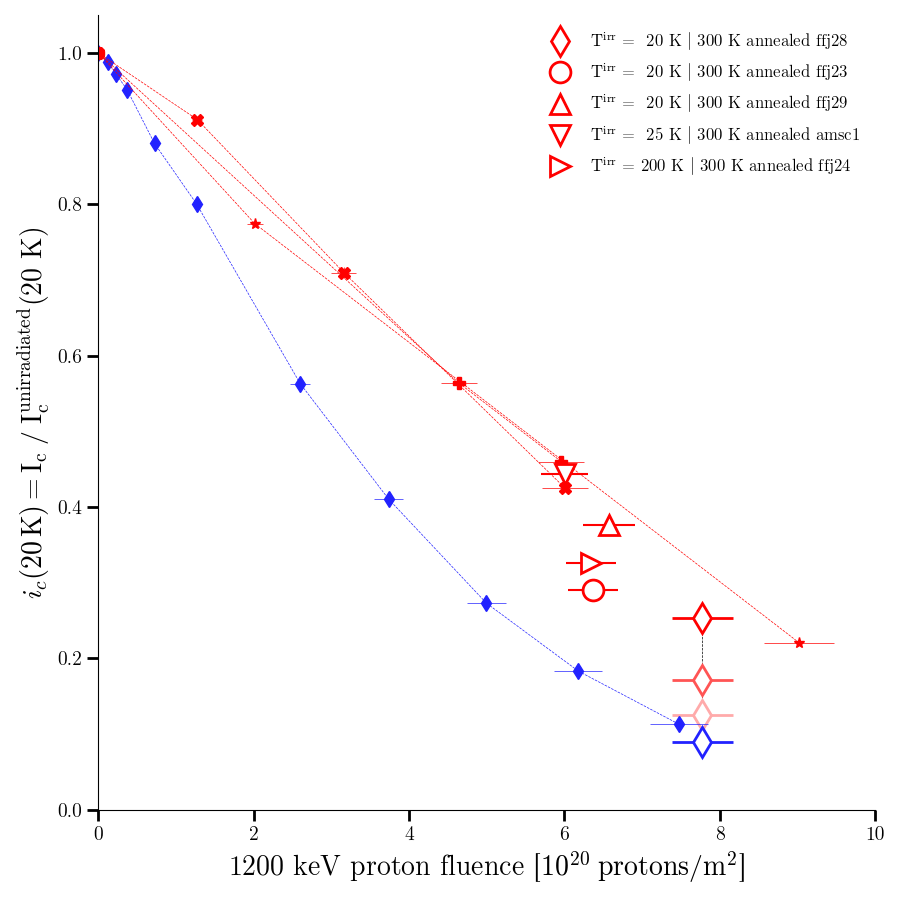

In [20]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(9, 9))
#ax.set_ylabel('$i_c\mathrm{(20\, K) = I_c\; /\; I_c^{unirradiated}}$')
ax.set_ylabel('$i_c \mathrm{(20 \, K) = I_c\; /\; I_c^{unirradiated}}$(20 K)')
ax.set_xlabel('1200 keV proton fluence [$\mathrm{10^{20}\; protons/m^2}$]')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 10)

tmin, tmax = 15, 30
ichi, fhi = [], []

cut = (metadata.tapes == '020k_ffj28')|np.array(['300k_' in s for s in metadata.tapes])
for tape, m in zip(metadata.tapes[cut], metadata.markers[cut]):
    
    tirr, l, c = get_metadata(tape)
    fpath = 'output/{}-ic_degradation.xlsx'.format(tape)
    data = pd.read_excel(fpath, sheet_name='aggregates')
    
    try:
        largest_number_fluence_steps = data[(tmin <= data.temperature_mean) & (data.temperature_mean<= tmax)].groupby('temperature_group').count().idxmax()[0]
        data = data[data['temperature_group']==largest_number_fluence_steps]
        
        # plot Ic in the top subfigure
        ic0 = data.ic_mean[data.cumulated_fluence == 0].values[0]
        x = data.cumulated_fluence/1e20
        y = data.ic_mean/ic0
        yerr = data.ic_std/ic0
        xerr = 0.05*x
        ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, marker=m, linestyle='--', linewidth=0.5, markersize=8, color=c, alpha=1)
        
        if tirr == 300:
            ichi.extend(data.ic_mean.values/ic0)
            fhi.extend(data.cumulated_fluence.values)
            
        else: # it is ffj28
            fpath = 'output/{}-ic_recovery_1_anneal.xlsx'.format(tape)
            recovery_data = pd.read_excel(fpath, sheet_name='aggregates')
            recovery_data = recovery_data[recovery_data.annealT != 150]
            
            max_fluence = pd.read_excel('020k_ffj28/fluence/Proton_2024_03_08-ffj28.xlsx', sheet_name='fluence_steps', usecols=[4]).iloc[0].values[0]
            
            x = np.ones(len(recovery_data.ic_mean))*max_fluence/1e20
            ax.plot(x, recovery_data.ic_mean/ic0, marker=m, color='k', linestyle='--', mec='None', linewidth=.5, zorder=-10*i)
            print(recovery_data.ic_mean/ic0)
            for i, row in recovery_data.iterrows():
                if row.annealT == 150:
                    ax.errorbar(x=x[0], xerr=0.05*x[0], y=row.ic_mean/ic0, yerr=row.ic_std/ic0, marker=m, mfc=palette(row.annealT/300), mec='k', ecolor='k', elinewidth=.5, markeredgewidth=.1, linestyle='None', zorder=-1*i, markersize=10)
                else:
                    ax.errorbar(x=x[0], xerr=0.05*x[0], y=row.ic_mean/ic0, yerr=row.ic_std/ic0, marker=m, mec=palette(row.annealT/300), mfc='white', markeredgewidth=2, ecolor=palette(row.annealT/300), elinewidth=2, linestyle='None', zorder=-1*i, markersize=15)
                
    except IndexError as e:
        print(tape, 'has no data for the temperature range ({}, {})'.format(tmin, tmax))

handles = []
_, l, _ = get_metadata('020k_ffj28') # add a handle for ffj28
handle = Line2D([0], [0], marker='d', color='r', linestyle='None', mfc='white', markeredgecolor='r', markeredgewidth=2, markersize=15, label=l[:-5]+'300 K annealed '+l[-5:])
handles.append(handle)

for tape in ['020k_ffj23', '020k_ffj29', '025k_amsc1', '200k_ffj24']:
    _, l, _ = get_metadata(tape)
    m = metadata[metadata.tapes==tape].markers.iloc[0]
    data = pd.read_excel('output/{}-anneal.xlsx'.format(tape), sheet_name='aggregates')
    ic_anneal300K = data[(data.anneal_temperature_K > 280)]
    ic_anneal300K = ic_anneal300K[ic_anneal300K.temperature_mean == ic_anneal300K.temperature_mean.min()]
    
    data = pd.read_excel('output/{}-ic_degradation.xlsx'.format(tape), sheet_name='aggregates')
    ic0 = data[data.cumulated_fluence == 0].ic_mean.max()
    x = ic_anneal300K.cumulated_fluence_mean/1e20
    ax.errorbar(x=x, xerr=0.05*x, y=ic_anneal300K.ic_mean/ic0, yerr=ic_anneal300K.ic_std/ic0, label=l+' annealed', marker=m, mfc='white', mec='r', ecolor='r',  markeredgewidth=2, zorder=2, markersize=15)
    handle = Line2D([0], [0], marker=m, color='r', linestyle='None', mfc='white', markeredgecolor='r', markeredgewidth=2, markersize=15, label=l[:-5]+'300 K annealed '+l[-5:])
    handles.append(handle)

ax.legend(frameon=False, handles=handles)
fig.tight_layout()

plt.savefig(savedir+'ic_degradation_recovery.png', transparent=False, dpi=300)

## $T_c$ degradation

In [70]:
ax.lines[0]

## Percentage in the thermal annealing of ffj28

In [68]:
0.125744-0.089630, 0.171965-0.125744, 0.254712-0.171965

(0.03611399999999999, 0.04622100000000001, 0.08274699999999999)

In [65]:
dTcdF_hot = np.mean([-0.01789941047877104, -0.016432677999826686, -0.016474623546221062])
dTcdF_cold = np.mean([-0.03149338399216551, -0.027754391364275953, -0.025690609654064223, -0.03192790811712944, -0.025779550417287155, -0.025119593470451708, -0.025809283871144017])

In [53]:
dTcdF_cold = np.mean([-2.8222732302199605, -2.4576632046906974, -2.2061343057836376, -2.9818234764076603, -2.284706577832928, -2.0947456396939215, -2.3025417549094023])
dTcdF_hot = np.mean([-1.5816245835831724, -1.4481303459245756, -1.5293199217355413])
dTcdF_hot, dTcdF_cold

(-1.5196916170810963, -2.4499840270768867)

<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/1816098583.py:56: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$\mathrm{T \, / \, T_c}$')


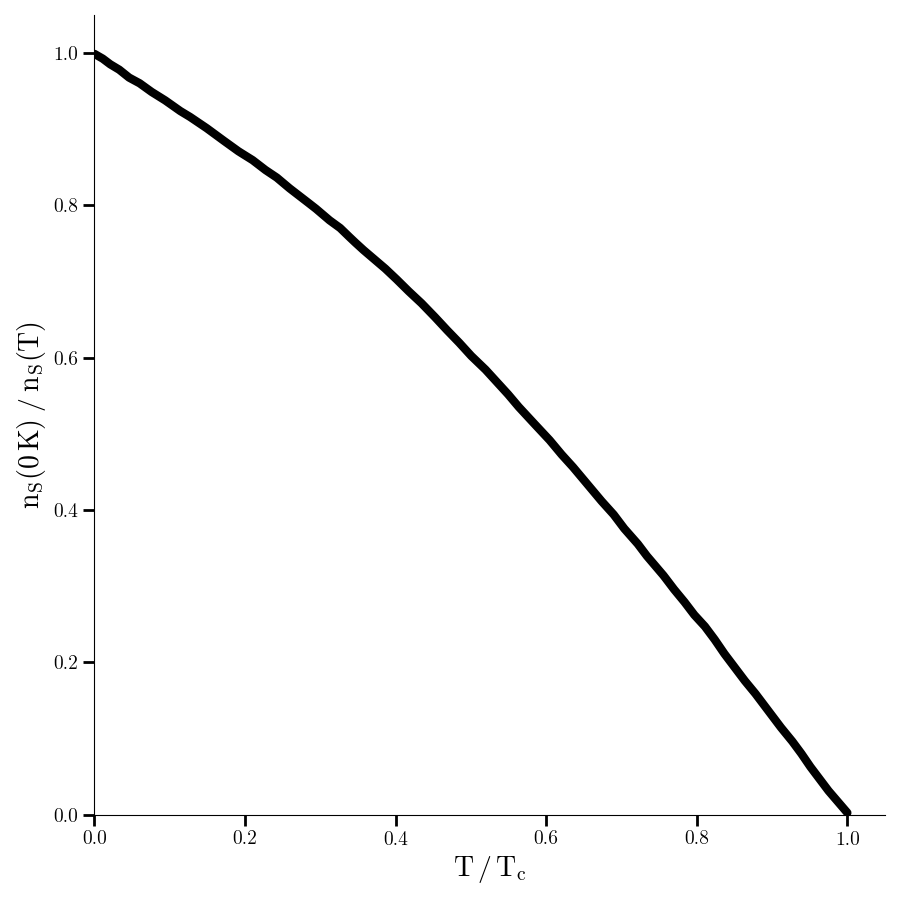

In [11]:
def get_rhos(tc, which='dwave'):
    if which == 'dwave':
        data = pd.read_csv('input/dwave_rhos_Won1994.csv', names=['tc', 'rhos'])
    else:
        data = pd.read_csv('input/swave_rhos_Won1994.csv', names=['tc', 'rhos'])
    return interp1d(data.tc, data.rhos, fill_value='extrapolate')(tc)

def get_gap(tc):
    data = pd.read_csv('input/dwave_gap_Won1994.csv', names=['tc', 'gap'])
    return interp1d(data.tc, data.gap, fill_value='extrapolate')(tc)

def get_jdp_temperature_correction(Tmeas, Tc, Tc0):
    return (get_gap(Tmeas/Tc)*get_rhos(Tmeas/Tc))/(get_gap(Tmeas/Tc0)*get_rhos(Tmeas/Tc0))
    
def get_selfH(ic, width, thickness):
    width *= 100     # convert SI to CGS
    thickness *= 100 # convert SI to CGS    
    jc = ic/(width*thickness) # Calculate current density
    return jc*thickness/10000   # Convert Oe to Tesla

def degradation_function(ic, tmeas, tc, tc0, n, n0):
    kappa_rho, alpha_p, nu0, phi0 = -16.5, 3., 2.5e7, constants.Planck/(2*constants.electron_volt)
    selfH = get_selfH(ic, 0.1e-3, 2e-6)
    
    Acreep = (1/(np.sqrt(phi0*selfH)*nu0))**(1/n-1/n0)
    Jdp = np.sqrt((alpha_p + 1)*(tc/tc0)**3/(alpha_p*(1-kappa_rho*(1-(tc/tc0))))+(tc/tc0))
    c = 1 #get_jdp_temperature_correction(tmeas, tc, tc0)
    
    print('Degradation function parameters...')
    print('kappa_rho = {:4.4e}'.format(kappa_rho))
    print('alpha_p = {:4.4e}'.format(alpha_p))
    print('nu0 = {:4.4e}'.format(nu0))
    print('phi0 = {:4.4e}'.format(phi0))
    print('selfH = ', selfH)
    print('n = ', n)
    print('n0 = ', n0)
    print('Tc = ', tc)
    print('Tc0 = ', tc0)
    print('Tmeas = ', tmeas)
    print('c = ', c)
    
    return c*Jdp*Acreep

def superfluid_density(tc, tmeas):
    return get_rhos(tmeas/(tc*89))*tc/(1+16.5*(1-tc))


xsmooth = np.linspace(0, 1, 1000)
rdsmooth, rssmooth = get_rhos(xsmooth), get_rhos(xsmooth, which='swave')

fig, ax = plt.subplots(figsize=(9, 9))    
#ax.plot(xsmooth, rssmooth, color='k', linewidth=4, linestyle='-.')
ax.plot(xsmooth, rdsmooth, color='k', linewidth=6)

ax.set_ylabel(r'$\mathrm{n_S(0 \, K)\; / \; n_S(T)}$')
ax.set_xlabel('$\mathrm{T \, / \, T_c}$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 1.05)

fig.tight_layout()
plt.savefig(savedir+'rho_s_tc_dwave.png', transparent=True, dpi=300)


<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/3545374102.py:2: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$\mathrm{\mathcal{D} = 1 - T_c \; / \; T_c^{unirradiated}}$')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/3545374102.py:3: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$i_c\mathrm{ = I_c \; / \; I_c^{unirradiated}}$')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/3545374102.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  largest_number_fluence_steps = ic_data[(tmin <= ic_data.temperature_mean) & (ic_data.

No measurements in temperature range [75, 85] for sample 020k_ffj28
attempt to get argmax of an empty sequence
No measurements in temperature range [75, 85] for sample 020k_ffj29
attempt to get argmax of an empty sequence


/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/3545374102.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  largest_number_fluence_steps = ic_data[(tmin <= ic_data.temperature_mean) & (ic_data.temperature_mean<= tmax)].groupby('temperature_group').count().idxmax()[0]
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/3545374102.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  largest_number_fluence_steps = ic_data[(tmin <= ic_data.temperature_mean) & (ic_data.temperature_mean<= tmax)].groupby('temperature_group').count().idxmax()[0]
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn

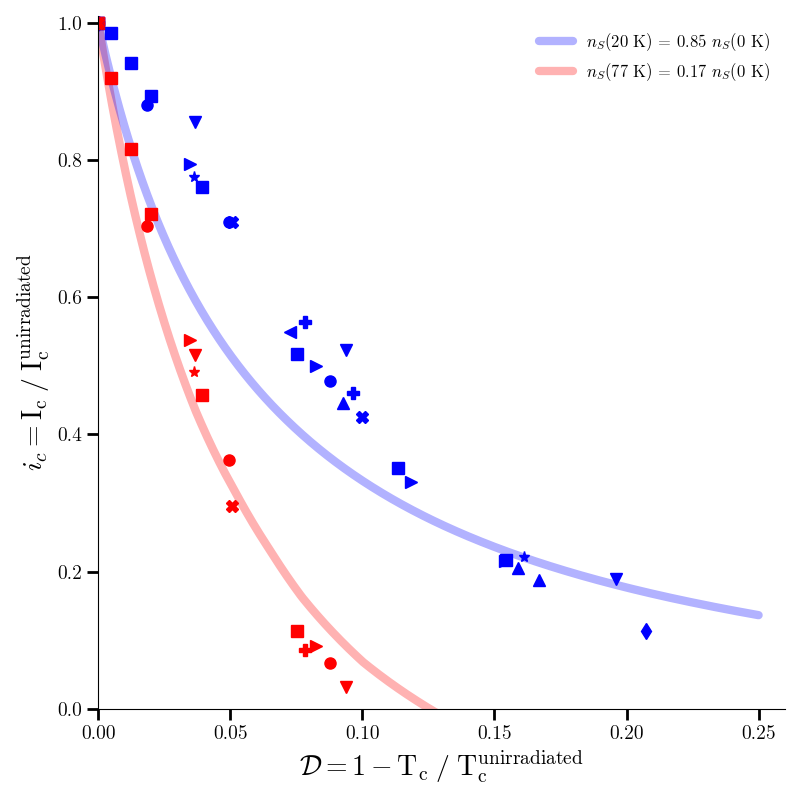

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel('$\mathrm{\mathcal{D} = 1 - T_c \; / \; T_c^{unirradiated}}$')
ax.set_ylabel('$i_c\mathrm{ = I_c \; / \; I_c^{unirradiated}}$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, .26)
ax.set_ylim(0, 1.01)

for tape, m in zip(metadata.tapes, metadata.markers):
    
    tc_data = pd.read_excel('output/{}-tc_degradation.xlsx'.format(tape), sheet_name='aggregates')
    ic_data = pd.read_excel('output/{}-ic_degradation.xlsx'.format(tape), sheet_name='aggregates')
    
    for tmin, tmax, c in zip([15, 75], [30, 85], ['b', 'r']):
        
        try:
            largest_number_fluence_steps = ic_data[(tmin <= ic_data.temperature_mean) & (ic_data.temperature_mean<= tmax)].groupby('temperature_group').count().idxmax()[0]
            data = ic_data[ic_data['temperature_group']==largest_number_fluence_steps]

            tc, ic, n = [], [], []
            for i, row in tc_data.iterrows():
                cut = (data.cumulated_fluence == row.cumulated_fluence)
                ic_step = data.ic_mean.loc[cut]
                n_step = data.n_mean.loc[cut]

                if len(ic_step) > 0:
                    tc.append(row.tc_mean)
                    ic.extend(ic_step)
                    n.extend(n_step)
                    
                    if row.cumulated_fluence == 0:
                        tc0 = row.tc_mean
                        ic0 = float(ic_step.iloc[0])
                        n0 = float(n_step.iloc[0])
                    
            x, y = 1-np.array(tc)/tc0, np.array(ic)/ic0
            ax.plot(x, y, marker=m, color=c, linestyle='None')
            
        except ValueError as e:
            print('No measurements in temperature range [{}, {}] for sample {}'.format(tmin, tmax, tape))
            print(e)
            
    #if tape == '020k_ffj28':
        #y = degradation_function(np.array(ic), ic_data.temperature_mean.mean(), tc, tc0, np.array(n), n0)
        #y = superfluid_density(tc, tc0)
        #ax.plot(x, y, linestyle='-', linewidth=4, alpha=0.5, color=c)

x = np.linspace(0.75, 1, 1000)        
y20k = superfluid_density(x, 20)
y77k = superfluid_density(x, 78)

ax.plot(1-x, y20k/y20k[-1], linestyle='-', linewidth=6, alpha=.3, color='b', zorder=-1, solid_capstyle='round', label=r'$n_S$(20 K) = {:4.2f} $n_S$(0 K)'.format(get_rhos(20/89)))
ax.plot(1-x, y77k/y77k[-1], linestyle='-', linewidth=6, alpha=.3, color='r', zorder=-2, solid_capstyle='round', label=r'$n_S$(77 K) = {:4.2f} $n_S$(0 K)'.format(get_rhos(77/89)))

ax.legend(frameon=False)
fig.tight_layout()
plt.savefig(savedir+'ic_degradation_ns.png', transparent=True, dpi=300)


<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/2350713199.py:8: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$i_c \mathrm{(20\, K) = I_c \; / \; I_c^{unirradiated}}$ (20 K)')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/2350713199.py:26: SyntaxWarning: invalid escape sequence '\m'
  label_fit = 'Arrhenius fit: $\mathrm{I_c}$ = '+'{:4.2f} exp({:4.2f} / '.format(*popt)+'$\mathrm{k_b T}$) + 2.95'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_17571/2350713199.py:26: SyntaxWarning: invalid escape sequence '\m'
  label_fit = 'A

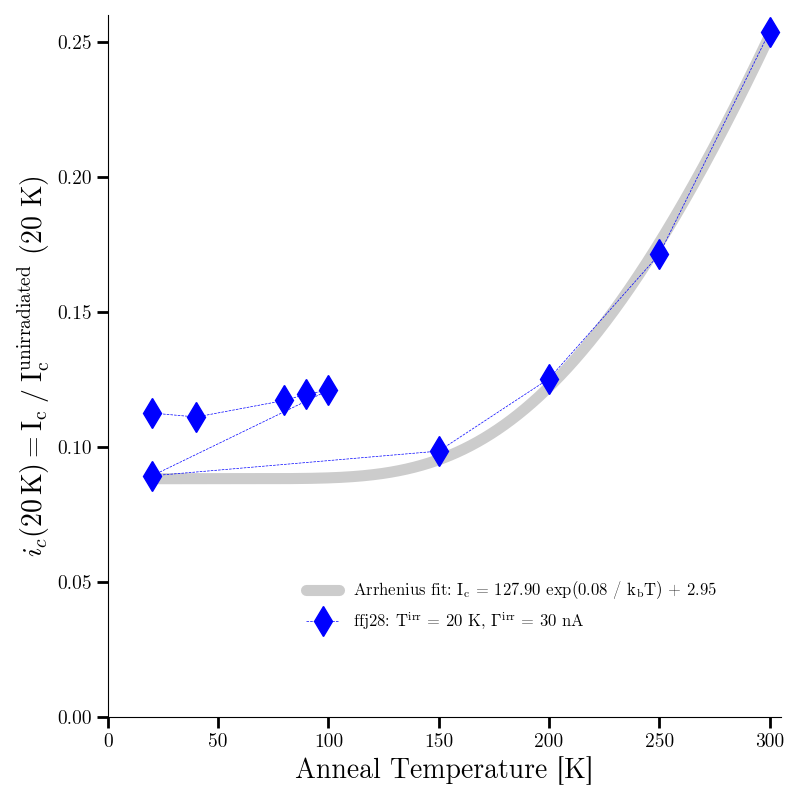

In [9]:
def arrhenius(T, a, ea):
    return a*np.exp(-1*ea/(cst.physical_constants['Boltzmann constant in eV/K'][0]*T))+2.95

fig, ax = plt.subplots()
#ax.set_xlabel('1200 keV proton fluence [$\mathrm{10^{20}\; p/m^2}$]')
ax.set_xlabel('Anneal Temperature [K]')
#ax.set_ylabel('$\mathrm{i_c = I_c \; / \; I_c^{unirradiated}}$ (20 K)')
ax.set_ylabel('$i_c \mathrm{(20\, K) = I_c \; / \; I_c^{unirradiated}}$ (20 K)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, 305)
ax.set_ylim(0, .26)

df = pd.read_excel('output/020k_ffj28-ic_degradation.xlsx', sheet_name='aggregates')
ic0 = df[(df['temperature_group'] == '[19.8, 20.3)') & (df['cumulated_fluence'] == 0)].ic_mean.iloc[0]

df0 = pd.read_excel('output/020k_ffj28-ic_recovery_0_anneal.xlsx', sheet_name='aggregates')
df1 = pd.read_excel('output/020k_ffj28-ic_recovery_1_anneal.xlsx', sheet_name='aggregates')
data = pd.concat([df0, df1])

popt, pcov = opt.curve_fit(arrhenius, data.iloc[5:].annealT, data.iloc[5:].ic_mean, p0=[1, 0.08])

xsmooth = np.linspace(20, 300, 1000)
ysmooth = arrhenius(xsmooth, *popt)/ic0

label_fit = 'Arrhenius fit: $\mathrm{I_c}$ = '+'{:4.2f} exp({:4.2f} / '.format(*popt)+'$\mathrm{k_b T}$) + 2.95'
ax.plot(xsmooth, ysmooth, linestyle='-', linewidth=8, alpha=.2, color='k', solid_capstyle='round', label=label_fit)
ax.errorbar(data.annealT, y=data.ic_mean/ic0, yerr=data.ic_std/ic0, linestyle='--', linewidth=.5, marker='d', markersize=15, color='b', label='ffj28: $\mathrm{T^{irr}}$ = 20 K, $\mathrm{\Gamma^{irr}}$ = 30 nA')
ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.6, 0.1))
fig.tight_layout()

plt.savefig(savedir+'icrecovery.svg', format='svg', transparent=True, dpi=300)

## For defense

The degradation rates for critical current are: rhot = -9.12 +/- 0.27 and rcold = -14.16 +/- 0.96


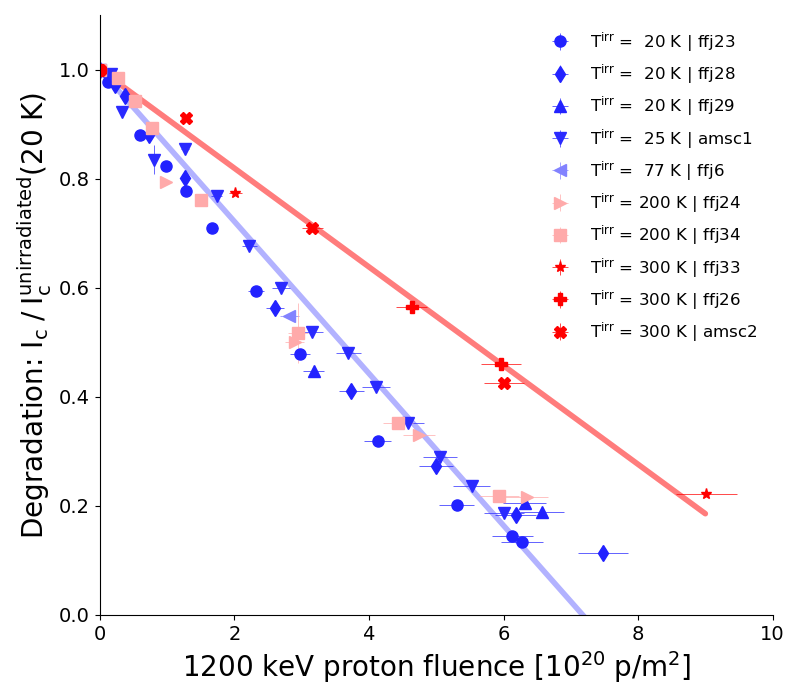

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7), sharex=True)
#ax.set_ylabel('$i_c\mathrm{(20\, K) = I_c\; /\; I_c^{unirradiated}}$')
ax.set_ylabel('Degradation: $\mathrm{I_c\; /\; I_c^{unirradiated}}$(20 K)')
ax.set_xlabel('1200 keV proton fluence [$\mathrm{10^{20}\; p/m^2}$]')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 1.1)
ax.set_xlim(0, 10)

tmin, tmax = 15, 30
iclo, ichi, flo, fhi = [], [], [], []
rcold_ic, rhot_ic = [], [] # collect the degradation rates

for tape, m in zip(metadata.tapes, metadata.markers):
    
    tirr, l, c = get_metadata(tape)
    fpath = 'output/{}-ic_degradation.xlsx'.format(tape)
    data = pd.read_excel(fpath, sheet_name='aggregates')
    
    try:
        largest_number_fluence_steps = data[(tmin <= data.temperature_mean) & (data.temperature_mean<= tmax)].groupby('temperature_group').count().idxmax()[0]
        data = data[data['temperature_group']==largest_number_fluence_steps]
        
        # plot Ic in the top subfigure
        ic0 = data.ic_mean[data.cumulated_fluence == 0].values[0]
        x = data.cumulated_fluence/1e20
        y = data.ic_mean/ic0
        yerr = data.ic_std/ic0
        xerr = 0.05*x
        ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, marker=m, linestyle='None', linewidth=0.5, markersize=8, color=c, label=l)
        
        popt, pcov = opt.curve_fit(linear_norm, x, data.ic_mean/ic0)
        rate_ic = popt[0]
        
        
        if tirr == 300:
            ichi.extend(data.ic_mean.values/ic0)
            fhi.extend(data.cumulated_fluence.values)
            rhot_ic.append(rate_ic)
        else:
            iclo.extend(data.ic_mean.values/ic0)
            flo.extend(data.cumulated_fluence.values)
            rcold_ic.append(rate_ic)
            
    except IndexError as e:
        print(tape, 'has no data for the temperature range ({}, {})'.format(tmin, tmax))


for i, (f, ic, c) in enumerate(zip([flo, fhi], [iclo, ichi], [palette(0), palette(1.)])):
    xsmooth = np.arange(0, 10, 1)
    
    # Fit the critical current data
    icpopt, _ = opt.curve_fit(linear_norm, np.array(f)/1e20, ic)
    ysmooth = linear_norm(xsmooth, *icpopt)
    if tirr == 300:
        ax.plot(xsmooth, ysmooth, color=c, zorder=0, linewidth=4, alpha=.3, solid_capstyle='round')

for i, (f, ic, c) in enumerate(zip([fhi], [ichi], [palette(1.)])):
    xsmooth = np.arange(0, 10, 1)
    
    # Fit the critical current data
    icpopt, _ = opt.curve_fit(linear_norm, np.array(f)/1e20, ic)
    ysmooth = linear_norm(xsmooth, *icpopt)
    ax.plot(xsmooth, ysmooth, color=c, zorder=0, linewidth=4, alpha=.3, solid_capstyle='round')

ax.legend(frameon=False)
fig.tight_layout()

savedir = '/Users/alexisdevitre/Desktop/phd-defense/'
plt.savefig(savedir+'ic_degradation_20K.svg', transparent=True, dpi=300)

print('The degradation rates for critical current are: rhot = {:4.2f} +/- {:4.2f} and rcold = {:4.2f} +/- {:4.2f}'.format(100*np.mean(rhot_ic), 100*np.std(rhot_ic), 100*np.mean(rcold_ic), 100*np.std(rcold_ic)))


In [ ]:
m2 = np.array([16, ]